In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from scipy.stats import multivariate_normal
import torch
from tqdm.notebook import tqdm

In [123]:
dataframe = pd.read_pickle('./dataframe.pkl')
dataframe

rows = dataframe.index.to_list()
rows = rows[:5] + rows[6:12] + rows[5:6] + rows[12:]
dataframe = dataframe.loc[rows]
dataframe

,eq,eq-error,eq-iterations,eq-num-params,matern,matern-error,matern-iterations,matern-num-params,noisy-mixture,noisy-mixture-error,...,weakly-periodic,weakly-periodic-error,weakly-periodic-iterations,weakly-periodic-num-params,weakly-periodic-slow,weakly-periodic-slow-error,weakly-periodic-slow-iterations,weakly-periodic-slow-num-params,marker,colour
Oracle-GP,1.4683259311331782,8.16821e-05,NaN,NaN,1.357630282476106,0.000100067,NaN,NaN,1.1539732765083448,0.00017514,...,0.7121964187778981,0.000212026,NaN,NaN,0.7237852505309083,0.00021212,NaN,NaN,NaN,NaN
Oracle-GP-diag,1.2643081354961447,0.000303363,NaN,NaN,1.059910389993622,0.000355754,NaN,NaN,0.5825508743772372,0.000540612,...,0.1063779150571311,0.000442576,NaN,NaN,0.11950711699007509,0.000445082,NaN,NaN,NaN,NaN
GNP-innerprod-homo,1.18057,0.0007885961734247794,101.0,182146.0,0.974643,0.0007458617996276045,101.0,182146.0,0.417124,0.0006211832519143041,...,-1.17735,0.0011058117370045955,101.0,182146.0,-1.2948,0.0026129391873229157,201.0,182146.0,o,tab:blue
GNP-kvv-homo,1.15461,0.00044341838103523787,101.0,182276.0,0.953926,0.0006066757714977253,101.0,182276.0,0.454561,0.0005902250769617974,...,-0.843011,0.0015058761252527907,101.0,182276.0,-0.500748,0.00367845511341524,201.0,182276.0,x,tab:blue
GNP-meanfield,-0.643821,0.009260277533114297,101.0,116226.0,-0.767541,0.008595382803274947,101.0,116226.0,-1.45449,0.0035964493878523464,...,-1.26013,0.0021356363721392927,101.0,116226.0,-3.09503,0.18448238078430265,201.0,116226.0,s,tab:blue
AGNP-innerprod-homo,1.34215,0.003045713140403298,101.0,805890.0,1.2159,0.004644257524287431,101.0,805890.0,-0.319072,0.033646100592023304,...,-1.18907,0.0010450986989123954,101.0,805890.0,-0.735149,0.001072925807282435,201.0,805890.0,o,tab:purple
AGNP-kvv-homo,1.33335,0.0033023662631462697,101.0,806020.0,1.22289,0.004391757313246264,101.0,806020.0,0.732976,0.006230868309506616,...,-0.33538,0.009018560475609097,101.0,806020.0,-0.426452,0.005708275758588912,187.0,806020.0,x,tab:purple
AGNP-meanfield,0.985103,0.016378838912399395,101.0,739970.0,0.784053,0.01713781399234428,101.0,739970.0,-1.53288,0.002367269164040765,...,-0.510658,0.01113802554399491,101.0,739970.0,-1.74852,0.0038811044012063973,201.0,739970.0,s,tab:purple
convGNP-innerprod-homo,1.44755,0.002370519268705244,101.0,55300.0,1.29197,0.004718475332760941,101.0,55300.0,0.531258,0.026893881761692856,...,-0.285237,0.009668137024649116,101.0,55300.0,-12.7294,0.29562188591275934,201.0,55300.0,o,tab:olive
convGNP-kvv-homo,1.44987,0.002424523219498982,101.0,55310.0,1.33934,0.003664449524072615,101.0,55310.0,1.09147,0.00779982181987836,...,0.269432,0.004754827481354355,101.0,55310.0,-9.6594,0.08023297106601607,201.0,55310.0,x,tab:olive


In [386]:
def plot_all_toy_results(df):
    
    data_names = ["eq",
                  "matern",
                  "noisy-mixture",
#                   "noisy-mixture-slow",
                  "weakly-periodic",
#                   "weakly-periodic-slow",
                  "sawtooth"]
    
    titles = ["EQ",
              "Matern",
              "Noisy mixture",
#               "Noisy mixture (slow)",
              "Weakly periodic",
#               "Weakly periodic (slow)",
              "Sawtooth"]
    
    labels = ["GNP (linear)",
              "GNP (kvv)",
              "GNP (meanfield)",
              "AGNP (linear)",
              "AGNP (kvv)",
              "AGNP (meanfield)",
              "ConvGNP (linear)",
              "ConvGNP (kvv)",
              "ConvGNP (meanfield)",
              "ANP",
              "ConvNP",
              "FullConvGNP"]
    
    yticks = [np.linspace(-1.0, 1.5, 6),
              np.linspace(-1.0, 1.5, 6),
              np.linspace(-1.5, 1.0, 6),
              np.linspace(-1.5, 0.5, 5),
              np.linspace(-0.5, 2.5, 4)]
    
    markers = ["P", "X", "s"] + ["<", ">", "p"] + ["^", "v", "h"] + ["d"] + ["D"] + ["*"]
    triplet = [60., 60., 60.]
    marker_sizes = [60., 60., 50.] + [60., 60., 70.] + [60., 60., 80.] + [60.] + [40.] + [100.]
    
    triplet = ['red', 'red', 'green']
    colors = triplet * 3 + ["purple"] + ["purple"] + ["orange"]
    
    fig = plt.figure(figsize=(12, 5))
    
    for i, d in enumerate(data_names):
        
        plt.subplot(1, len(data_names), i+1)
        
        x = np.arange(len(df[d]) + 2)
        ones = np.ones_like(x)
        y = df[d]
        e = df[d + '-error']
        oracle_result = df[d]["Oracle-GP"]
        oracle_error = df[d + "-error"]["Oracle-GP"]
        oracle_diag_result = df[d]["Oracle-GP-diag"]
        oracle_diag_error = df[d + "-error"]["Oracle-GP-diag"]

        for j in range(2, len(labels)+2):
            
            if i == len(data_names) - 1:
                plt.scatter(x[j], y[j], marker=markers[j-2], s=marker_sizes[j-2], color=colors[j-2], linewidth=1.2, edgecolor='k', zorder=2, label=labels[j-2])
#                 plt.errorbar(x[j], y[j], e[j], marker=markers[j-2], color=colors[j-2], linewidth=1.2, zorder=1)
            
            else:
                plt.scatter(x[j], y[j], marker=markers[j-2], s=marker_sizes[j-2], color=colors[j-2], linewidth=1.2, edgecolor='k', zorder=2)
#                 plt.errorbar(x[j], y[j], e[j], marker=markers[j-2], color=colors[j-2], linewidth=1.2, zorder=1)
#                 plt.setp(axis, ylim=axis[0].get_ylim())
                
#         for j in range(3):
#             idx = 2 + j + np.arange(0, 7, 3)
#             plt.plot(idx, y[idx], color='gray', zorder=1, alpha=0.3)

        plt.plot(x, oracle_result * ones, label='GP Oracle', color='k', zorder=1)
        plt.plot(x, oracle_diag_result * ones, '--', label='GP Oracle (diag.)', color='k', zorder=1)
        plt.fill_between(x,
                         (oracle_result + oracle_error) * ones,
                         (oracle_result - oracle_error) * ones,
                         color='k', alpha=0.1)

        plt.xticks([])
        plt.title(titles[i])
        plt.xlim([0., 14])
        
        if i == 0:
            plt.ylabel('Log. likelihood', fontsize=18)
    
        ylims = [(-1.10, 1.65),
                 (-1.10, 1.53),
                 (-1.75, 1.35),
                 (-1.75, 0.90),
                 (-0.60, 2.6)]
            
        plt.yticks(yticks[i])
        plt.ylim(ylims[i])
        
        
    handles, labels = plt.gca().get_legend_handles_labels()
#     fig.legend(handles[:2], labels[:2], loc='right', ncol=2, fontsize=13)

    fig.legend(handles[:2], labels[:2], loc='lower left', ncol=1, fontsize=13)
    fig.legend(handles[2:], labels[2:], loc='lower center', ncol=4, fontsize=13)

    plt.tight_layout()
    fig.subplots_adjust(bottom=0.22)
    plt.savefig("./plots/toy-results.pdf")
    plt.show()

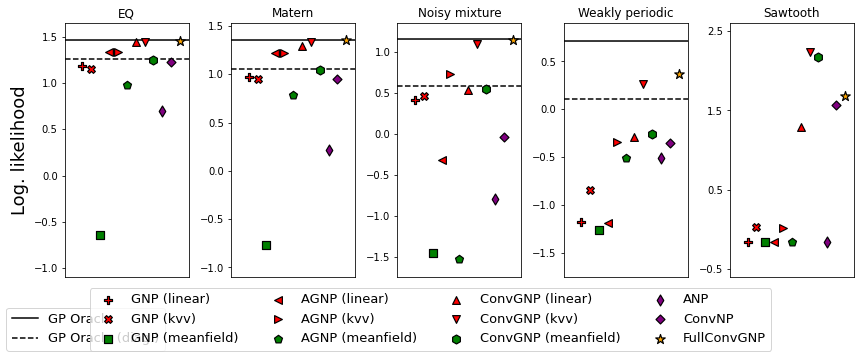

In [387]:
plot_all_toy_results(dataframe)